In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn

from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RESDIR='../output/train_eval/'

In [74]:
# Checking distributions 
from scipy.stats import mannwhitneyu, ttest_ind

def plot_aaprops(vals, label_column='agg_label', rank_column='trueHLA_EL_rank', title = 'Different AA properties on CEDAR\nONE-SIDED MW-U and Welch tests'):
    pal = sns.color_palette('hsv', n_colors = 13)
    sns.set_palette([pal[-4], pal[-1]])
    f,a = plt.subplots(8,2, figsize = (10, 32))
    ax = a.ravel()
    
    hue = [label_column]
    for i,key in enumerate([rank_column, 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 
                            'isoelectric_point', 'PD2',  'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']):
        gb=vals.groupby(label_column)[key].agg(['mean', 'median'])
        med_0 = gb.loc[0,'median']
        med_1 = gb.loc[1, 'median']
        sns.histplot(data = vals, x = key, hue=label_column, alpha = 0.4, 
                     kde=True, ax=ax[i], legend=True, hue_order=[0,1])
        # Reset max ylim
        upper = ax[i].get_ylim()[1]
        ax[i].set_ylim([0, upper* 1.15])
        
        # Mann Whitney U test
        pos, neg = vals.query(f'{label_column}==1')[key].values, vals.query(f'{label_column}==0')[key].values
        
        alt_t = 'greater' if pos.mean()>neg.mean() else 'less'
        """
        ‘less’: the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.
        """
        alt_mw = 'less' if pos.mean() < neg.mean() else 'greater'
        
        _, pval_mw = mannwhitneyu(pos, neg, alternative=alt_mw)
        _, pval_t = ttest_ind(pos,neg, equal_var = False, alternative=alt_t)
        
        
        sig_mw = f'ns; p={pval_mw:.3f}' if pval_mw>0.05 else f'*, p={pval_mw:.2e}'
        sig_t = f'ns; p={pval_t:.3f}' if pval_t>0.05 else f'*, p={pval_t:.2e}'
        ax[i].set_title(f'MW-U: {sig_mw}; Welch test: {sig_t}')
        # Reset ax if HLA rank
        if key == rank_column:
            ax[i].set_xlim([0,20])
            
        # Drawing axvlines
        ax[i].axvline(x=med_0, label = 'Median 0', ls = '--', lw = '.65', color='b' )
        ax[i].axvline(x=med_1, label = 'Median 1', ls = '--', lw = '.65', color='m')
        # Get the fucking rectangles from sns plots
        legend = ax[i].get_legend()
        handles = legend.legendHandles
        # Combine to the fucking lines from plt/ax plots
        handles.extend(ax[i].get_legend_handles_labels()[0])
        # Set the labels manually like a dog
        labels = ["Label = 0", "Label = 1", "Median 0", "Median 1"]
        # Reset the legend manually like a dog
        ax[i].legend(handles = handles, labels = labels)
    f.suptitle(f'{title}', fontweight= 'semibold',fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.955)

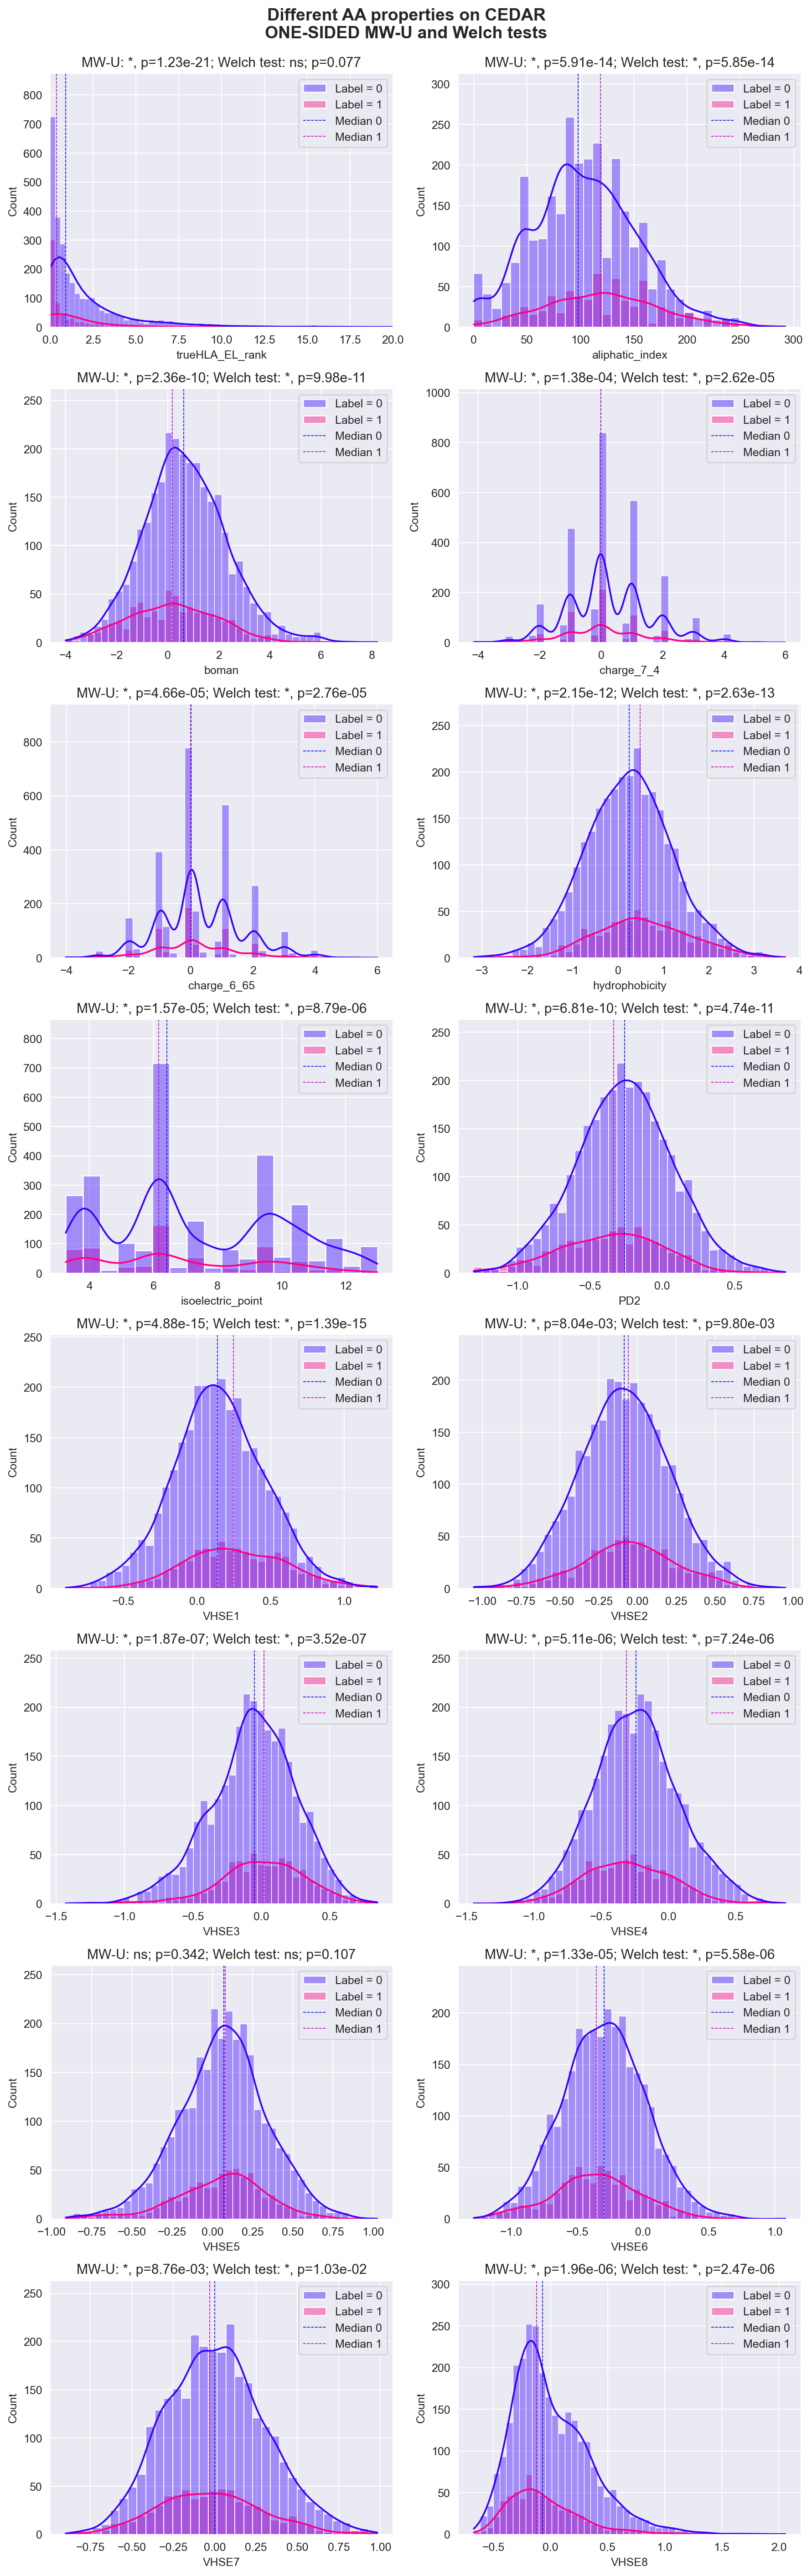

In [75]:
plot_aaprops(df)

In [45]:
from src.data_processing import get_aa_properties
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
prime = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
df, index = get_aa_properties(cedar)
df_p, _ = get_aa_properties(prime, 'Peptide')
df = df[['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank']+index]
df_p = df_p[['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank']+index]

Text(0.5, 1.0, 'Spearman correlation on CEDAR data')

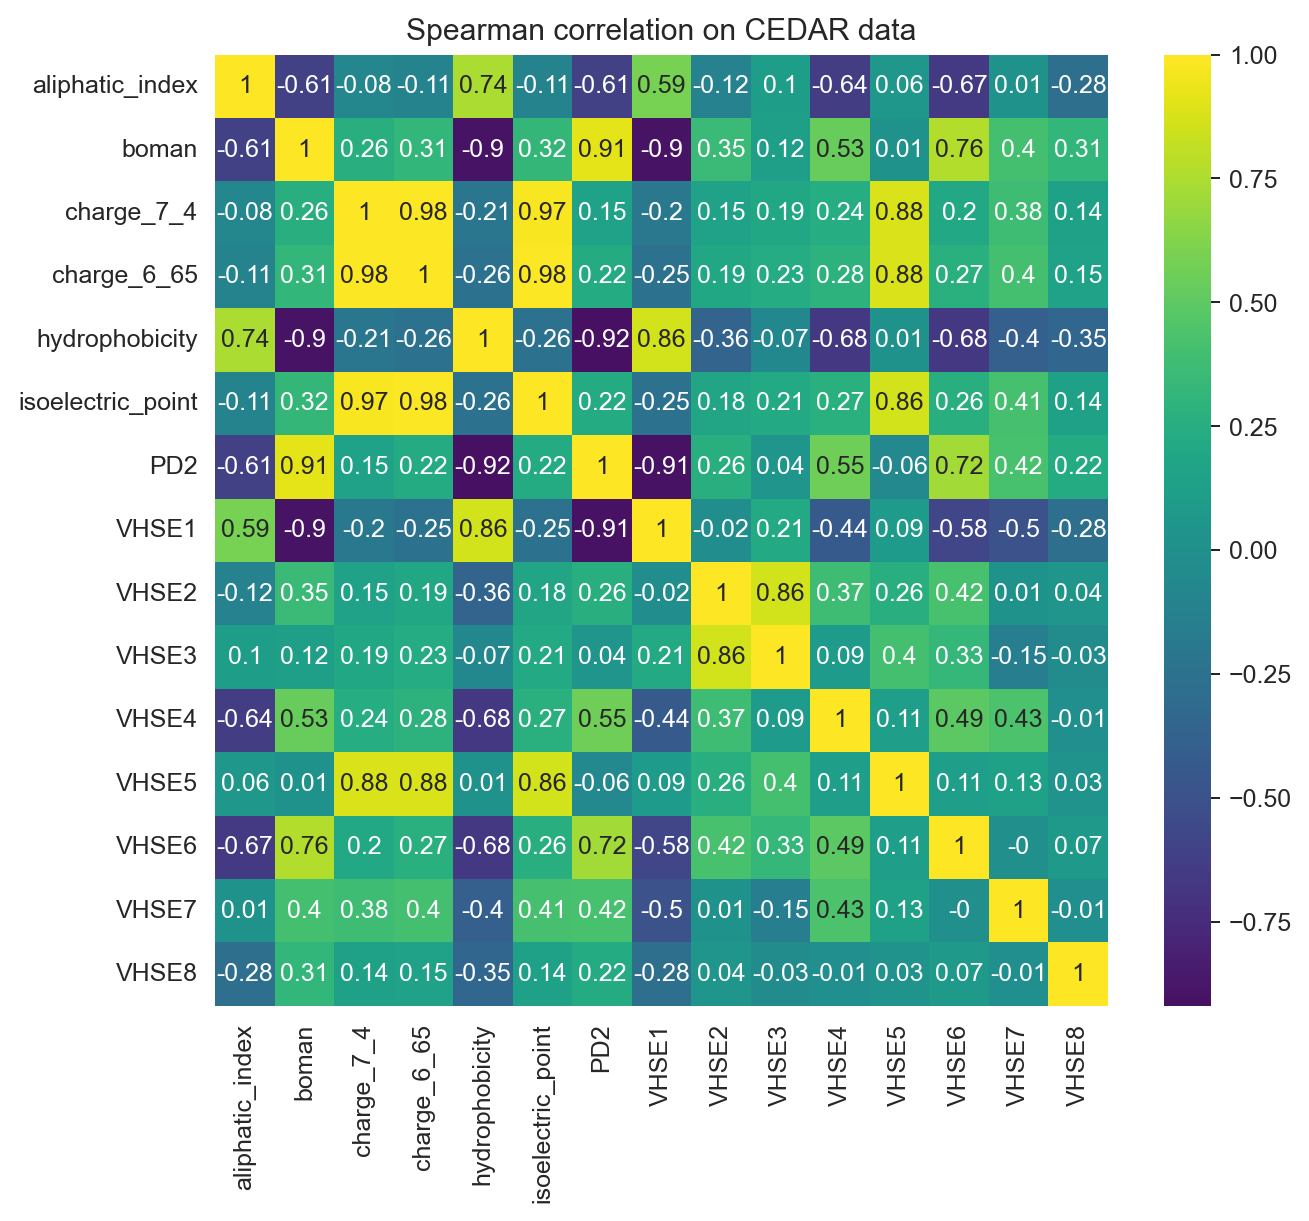

In [49]:
f,a = plt.subplots(1,1, figsize=(8,7))
sns.set_palette('viridis')
corr = df[index].corr('spearman')
sns.heatmap(corr.round(2), center=0, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on CEDAR data')

Text(0.5, 1.0, 'Spearman correlation on PRIME data')

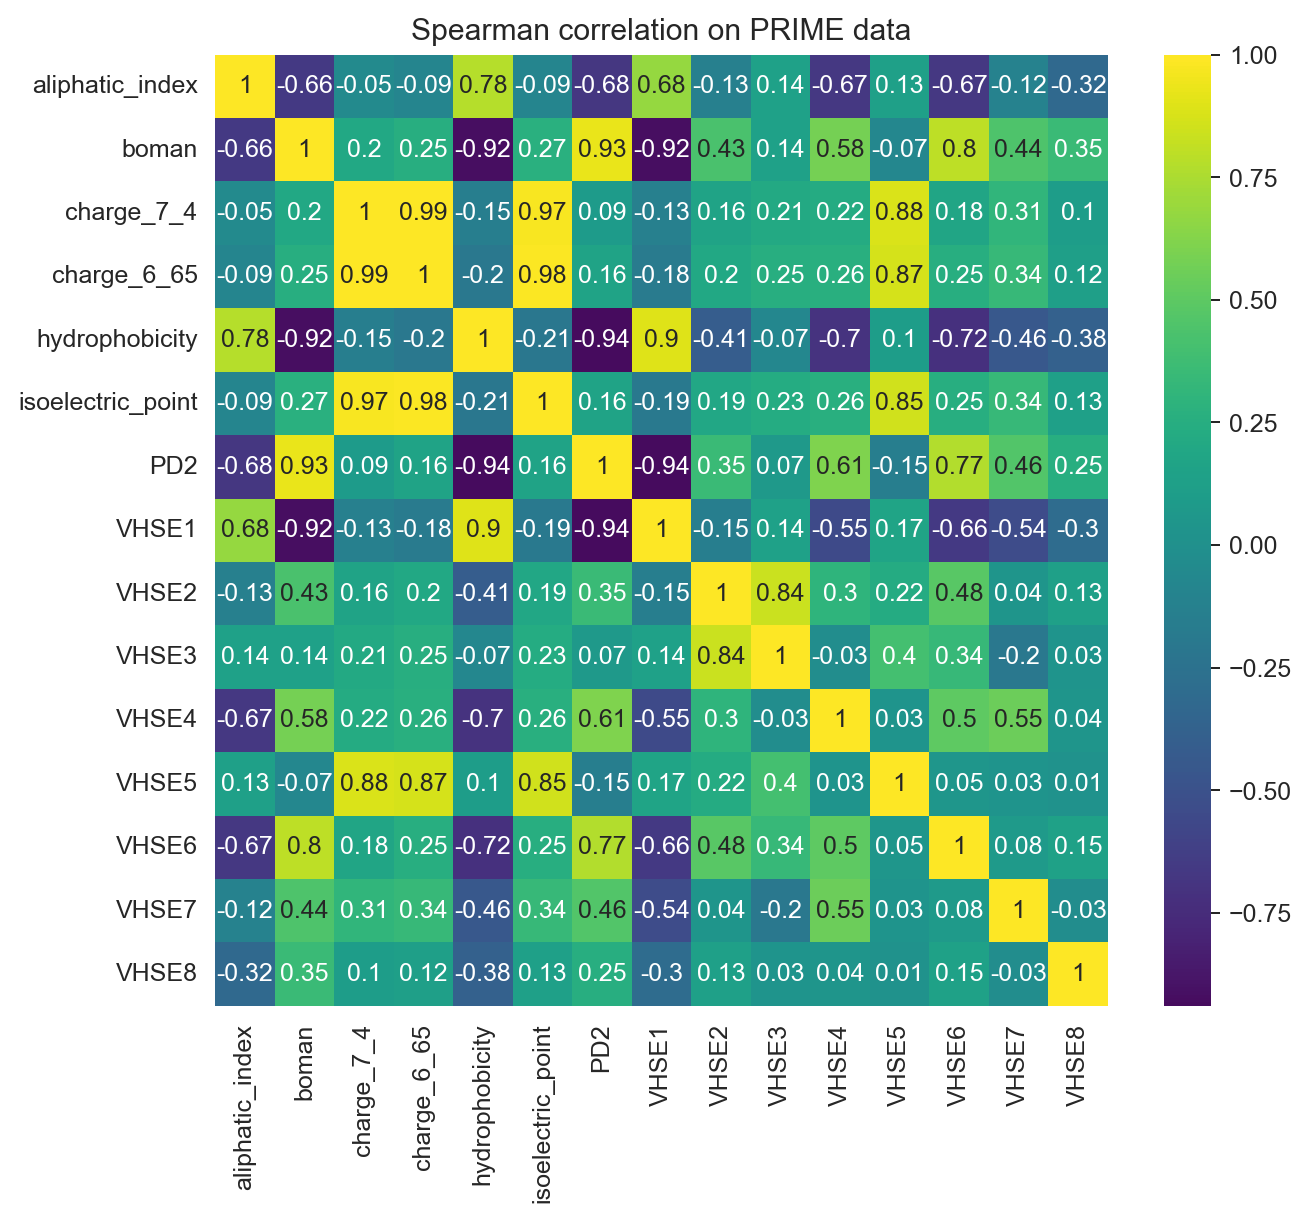

In [48]:
f,a = plt.subplots(1,1, figsize=(8,7))
sns.set_palette('viridis')
corr_p = df_p[index].corr('spearman')
sns.heatmap(corr_p.round(2), center=0, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on PRIME data')

## backward selection 

In [ ]:
selected_columns = index
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

# df.iloc[:, 4:]
SL = 0.05
data_modeled, selected_columns = backwardElimination(df[index].values, 
                                                     df['agg_label'].values, 
                                                     SL, selected_columns)

In [ ]:
selected_columns

array(['boman', 'charge_7_4', 'charge_6_65', 'PD2', 'VHSE3', 'VHSE5',
       'VHSE6', 'VHSE8'], dtype='<U17')

## Manual selection

Based on these plots:

1. Aliphatic index correlates with Hydrophobicity (0.74) and VHSE1 (0.59).

**But would like to keep both Aliphatic index and Hydrophobicity. Could get rid of VHSE1. VHSE has very low p value (x e-15) for sep**

2. BOMAN and PD2 highly correlate (0.91), and some correlation with VHSE4 and 6 (0.53 and 0.76) --> Drop VHSEs?



3. should collapse charges into keeping only isoelectric point as it has the lowest p value for separating. VHSE_5 correlates a bit with it also, and has high pvalue (not significant) in the aaprops dist plot, so should be dropped

--> Charge 6.65, charge 7.4, VHSE_5 into isoelectric pt.

3. VHSE2 and 3 should be collapsed into a single one, keeping only 3.

In [78]:
index
keep = ['aliphatic_index', 'boman', 'hydrophobicity',
        'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8']

## Trying some stuff with new features and also ONLY rank as feature/model

In [102]:
from src.train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

In [120]:
from copy import deepcopy
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
prime = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime = prime.query('Peptide not in @cedar.Peptide.unique()')

rf = RandomForestClassifier(n_estimators = 250, max_depth=3, ccp_alpha=0.0)
# only rank
rank_kwargs = {'max_len': 12,
               'encoding': 'onehot',
               'blosum_matrix': None,
               'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
               'add_rank': True,
               'add_aaprop': False,
               'remove_pep': True,
               'standardize': True}

rank_model, rank_train_metrics, rank_test_metrics = nested_kcv_train_sklearn(cedar, rf, None, rank_kwargs)

rank_cedar_results = evaluate_trained_models_sklearn(cedar, rank_model, None, train_dataframe = cedar,
                                                     train_metrics = rank_train_metrics, encoding_kwargs = rank_kwargs,
                                                     concatenated=True, keep=True)
rank_prime_results = evaluate_trained_models_sklearn(prime, rank_model, None, train_dataframe = None,
                                                       train_metrics = rank_train_metrics, encoding_kwargs = rank_kwargs,
                                                       concatenated=True, keep=True)
# only aaprop
aaprop_kwargs = deepcopy(rank_kwargs)
aaprop_kwargs.update({'add_rank':False,
                      'add_aaprop':True})
aaprop_model, aaprop_train_metrics, aaprop_test_metrics = nested_kcv_train_sklearn(cedar, rf, None, aaprop_kwargs)
aaprop_cedar_results = evaluate_trained_models_sklearn(cedar, aaprop_model, None, train_dataframe = cedar,
                                                       train_metrics = aaprop_train_metrics, encoding_kwargs = aaprop_kwargs,
                                                       concatenated=True, keep=True)
aaprop_prime_results = evaluate_trained_models_sklearn(prime, aaprop_model, None, train_dataframe = None,
                                                       train_metrics = aaprop_train_metrics, encoding_kwargs = aaprop_kwargs,
                                                       concatenated=True, keep=True)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [126]:
aaprop_prime_results['concatenated']['auc']

0.67063387555488

In [134]:
dummies = pd.get_dummies(cedar, columns=['HLA'])
dummies[[x for x in dummies.columns if x.startswith('HLA_')]]# in x]]

,HLA_HLA-A01:01,HLA_HLA-A02:01,HLA_HLA-A02:02,HLA_HLA-A02:03,HLA_HLA-A02:05,HLA_HLA-A02:06,HLA_HLA-A02:10,HLA_HLA-A02:11,HLA_HLA-A02:24,HLA_HLA-A03:01,HLA_HLA-A03:02,HLA_HLA-A11:01,HLA_HLA-A11:02,HLA_HLA-A24:02,HLA_HLA-A25:01,HLA_HLA-A26:01,HLA_HLA-A29:02,HLA_HLA-A30:01,HLA_HLA-A30:02,HLA_HLA-A31:01,HLA_HLA-A33:01,HLA_HLA-A68:01,HLA_HLA-A68:02,HLA_HLA-A69:01,HLA_HLA-B07:02,HLA_HLA-B08:01,HLA_HLA-B13:02,HLA_HLA-B15:01,HLA_HLA-B18:01,HLA_HLA-B27:05,HLA_HLA-B35:01,HLA_HLA-B35:03,HLA_HLA-B37:01,HLA_HLA-B37:04,HLA_HLA-B38:01,HLA_HLA-B39:01,HLA_HLA-B39:06,HLA_HLA-B40:01,HLA_HLA-B40:02,HLA_HLA-B41:02,HLA_HLA-B44:02,HLA_HLA-B44:03,HLA_HLA-B44:08,HLA_HLA-B49:01,HLA_HLA-B51:01,HLA_HLA-B52:01,HLA_HLA-B54:01,HLA_HLA-B56:01,HLA_HLA-B57:01,HLA_HLA-C01:02,HLA_HLA-C03:03,HLA_HLA-C03:04,HLA_HLA-C04:01,HLA_HLA-C05:01,HLA_HLA-C06:02,HLA_HLA-C07:01,HLA_HLA-C07:02,HLA_HLA-C08:02,HLA_HLA-C12:02,HLA_HLA-C12:03,HLA_HLA-C14:02,HLA_HLA-C14:03,HLA_HLA-C15:02
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3476,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3477,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3478,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# re-reading results

In [2]:
run1 = pkl_load('../output/run_220901_22h56m32s/tune_results_models.pkl')
run2 = pkl_load('../output/run_220902_14h13m49s/tune_results_models.pkl')

In [3]:
from src.utils import flatten_product
from itertools import product

encode_blosum_zip = zip(['onehot', 'blosum', 'blosum'], [None, 1, 1])
        # Weighting zip (ic dict, ic name, mask bool)
ics_mask_zip = zip([1, 1, 1, 1], ['Shannon', 'KL', 'None', 'Mask'],
                       [False, False, False, True])
# True/False zips for add_rank, add_aaprop, remove_pep
features_zip = zip([True, True, False, False],
                       [True, False, True, False],
                   [False, False, False, False])

# Lone conditions (to be producted so not zipped)
train_datasets = [1, 1, 1, 1]
standardize_ = [True]

# Here make the conditions that don't rely on hyperparams, i.e. all dataset and dataprocessing conditions
conditions = list(list(product(train_datasets,
                     product(encode_blosum_zip,
                         product(ics_mask_zip,
                                 product(features_zip,
                                         product(standardize_)))))))



In [4]:
len(conditions)*2

384